In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys

# ### settings for running training loop using a specified Google Drive account
from google.colab import drive
drive.mount('/content/gdrive')
gdrive_path = "/content/gdrive/MyDrive/"

### Hardware agnostic settings
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print('Default tensor type is now cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
print("Device in use is: ", device)


root = gdrive_path + ''
sys.path.append(root + 'Code')
sys.path.append(root + 'Code/DataGeneration')

"""
Code used to generate synthetic data for the graph coupled dynamical system examples and the single network examples when q=1.
"""

Mounted at /content/gdrive
Default tensor type is now cuda
Device in use is:  cuda


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


In [ ]:

def get_Network(n, k):

  """
  Function for randomly generating k-contracting Networks.
  args:
        n: state dimension.
        k: k-contraction dimension.
  returns:
        A: Network parameter.
        B: Network parameter.
        C: Network parameter.
       bx: Network parameter.
        P: k-contraction metric.
  """

  if k == 1: # 1 contracting opinion dynamics.
      a = 1.5
      A = -a*torch.eye(n)
      B = 0.5*torch.eye(n)
      C = 1.0*torch.tensor([[1, -1, 0],
                        [-1, 1, -1],
                        [0, -1, 1]])
      bx = torch.zeros(n); bx[0] = 0.2; bx[2] = -0.2;
      P = (1/a) * torch.eye(n)

  elif k == 2: # 2 contracting Hopfield network.
      a = 2.5
      A = -a*torch.eye(n)
      B = torch.ones(n,n)
      C = torch.eye(n)
      bx = torch.zeros(n)
      P = (1/a) * torch.eye(n)

  elif k == 3: # 3 contracting simple attractor.
      A = torch.tensor([[0, 1, -2],
                        [-1, 0, -1],
                        [0.5, 0, -0.5]])

      B = torch.zeros(n,n); B[2,0] = -0.5;

      C = torch.zeros(n,n); C[2,0] = 1;

      bx = torch.zeros(n)

      A_sym = A + A.t()
      alpha_k = torch.topk( torch.linalg.eigvals(A_sym).real, 3 ).values
      alpha_k = torch.sum(alpha_k)
      alpha_k = ( 1/6 ) * alpha_k
      P = -(1/alpha_k) * torch.eye(n)

  else:
      A = None
      B = None
      C = None
      bx = None
      P = None
      print('Returned None!')

  return A, B, C, bx, P


In [3]:

def test_Network(k, g, A, B, C):

  """
  Function for testing the Network is k-contracting. Printed statements will provide
  information on whether the test passed.
  args:
         k: k-contraction dimension.
         g: Upper bound on slope of nonlinearity.
         A: Network parameter.
         B: Network parameter.
         C: Network parameter.
  returns:
      test: True if test was passed.
  """

  # Calculate alpha_k
  A_sym = A + A.t()

  z = torch.topk( torch.diag(A_sym), k ).values
  z2 = torch.sum(z)
  alpha_k = ( 1/(2*k) ) * z2

  # Singular values of B
  _, s, _ = torch.linalg.svd(B)
  s2 = torch.topk( s, k ).values
  s3 = s2 * s2

  # LHS of (3)
  LHS = g * g * torch.sum(s3)

  # RHS of (3)
  RHS = alpha_k * alpha_k * k

  # Test
  if alpha_k < 0 and LHS < RHS:
    string = 'Network is {0}-contracting!'.format(k)
    print(string)
    test = True
  else:
    string = 'Network is NOT {0}-contracting!'.format(k)
    print(string)
    test = False

  return test


In [4]:

def get_qNetworks(q, n, k, g):

  """
  Collect q independent Networks into a single system.
  args:
          q: number of independent networks to combine.
          n: state dimension of independent networks.
          k: k-contraction dimension. Note test_Network(k-1, g, A, B, C) will fail if k=1!
          g: slope bound.
  return:
          A: block diagonal combined network parameter.
          B: block diagonal combined network parameter.
          C: block diagonal combined network parameter.
         bx: q stacked network biases.
          P: block diagonal k-contraction metric.
  """

  A, B, C, bx, P = get_Network(n, k)

  string = 'Network 0 is done.'
  print(string)

  for i in range(1,q):
    A2, B2, C2, bx2, P2 = get_Network(n, k)

    A = torch.block_diag(A, A2)
    B = torch.block_diag(B, B2)
    C = torch.block_diag(C, C2)
    P = torch.block_diag(P, P2)
    bx = torch.cat([bx, bx2], dim=0 )

    string = 'Network {0} is done.'.format(i)
    print(string)

  return A, B, C, bx, P


In [ ]:

def get_L(q, n, P):

  """
  Randomly generate graph coupling matrix, L, according Theorem 7 and Remark 3 (no self-loops).
  args:
          q: number of independent networks to couple.
          n: state dimension of independent networks.
          P: block diagonal k-contraction metric for q independent networks.
  return:
          L: graph coupling matrix.
  """

  mask_block = torch.ones(n, n)
  mask = mask_block
  for i in range(q-1):
    mask = torch.block_diag(mask, mask_block)

  mask = torch.ones(q*n, q*n) - mask

  GL = 0.025*torch.rand(q*n, q*n) - 0.0125 # to avoid generating a (k-1)-contracting system
  GL = GL * mask

  L = torch.matmul( GL.t(), P )
  L = torch.matmul( torch.inverse(P), L )
  L = GL - L

  return L


In [ ]:

def simulate(time, x0, A, B, C, bx):

  """
  Function for simulating the q interacting networks. Will need to manually change the dynamics implemented in the for loop depending on the example.
  See Appendix D.
  args:
        time: array containing inital time, final time and integration step.
          x0: initial conditions.
           A: block diagonal combined network parameter + graph coupling matrix.
           B: block diagonal combined network parameter.
           C: block diagonal combined network parameter.
          bx: q stacked network biases.
  returns:
           T: tensor containing the time array.
           X: (N, tmax, q*n) tensor containing N trajectories of the combined networks.
  """

  T = torch.from_numpy( np.arange(time[0], time[1]+time[2], time[2]) ).float()
  N, tmax, _ = X.shape
  step = time[2]

  X = []
  Xi = x0.t()
  X.append(Xi)

  for i in range(tmax-1):
    Yi = torch.matmul(C, Xi)
    f = torch.matmul(A, Xi)  + torch.matmul( B, Yi**3  ) + torch.tile( bx, (N,1) ).t()
    Xi = Xi + step * f
    X.append(Xi)

  X = torch.stack(X, dim=0) # (tmax, q*n, N)
  X = torch.transpose(X, 0, 2) # (N, q*n, tmax)
  X = torch.transpose(X, 1, 2) # (N, tmax, q*n)

  return T, X


In [ ]:
# Global Variables
data_path = root + 'Data/'
name = 'Graph Coupled Simple Attractor'
title = 'Graph Coupled Simple Attractor'
OOD = True # Set to true when generating out of distribution data.
N = 100 # number of trajectories to generate.
time = np.array([0.0, 30.0, 1e-2]) # inital, final, integration step

# Generate q interacting networks, each with state dimension n, and test it is k-contracting.
q=10
n=3
k=3
g=1.0 # upper bound on slope.
AG, BG, CG, bxG, PG = get_qNetworks(q, n, k, g)
L = get_L(q, n, PG)

# Uniformly sample initial conditions for training data or out of distribution data.
min_axis1 = -3.0
max_axis1 = 3.0

if OOD:
    x0_upp = np.random.uniform( max_axis1, max_axis1+3, (q*n)*int(N/2) )
    x0_low = np.random.uniform( min_axis1-3, min_axis1, (q*n)*int(N/2) )
    min_axis1 = (min_axis1-3)*np.ones((q*n,))
    max_axis1 = (max_axis1+3)*np.ones((q*n,))
    x0 = np.concatenate( (x0_low, x0_upp) )
    np.random.shuffle(x0)
    x0 = np.reshape( x0, (N,q*n) )
else:
    min_axis1 = min_axis1*np.ones((q*n,))
    max_axis1 = max_axis1*np.ones((q*n,))
    x0 = np.random.uniform( min_axis1, max_axis1, (N,q*n) )

x0 = torch.from_numpy(x0).float().to(device) # (N, q*n)

# Simulate q interacting graph coupled networks. 
# Remove L and set q=1 for single networks.
T, X = simulate(time, x0, AG+L, BG, CG, bxG)


Network 0 is done.
Network 1 is done.
Network 2 is done.
Network 3 is done.
Network 4 is done.
Network 5 is done.
Network 6 is done.
Network 7 is done.
Network 8 is done.
Network 9 is done.


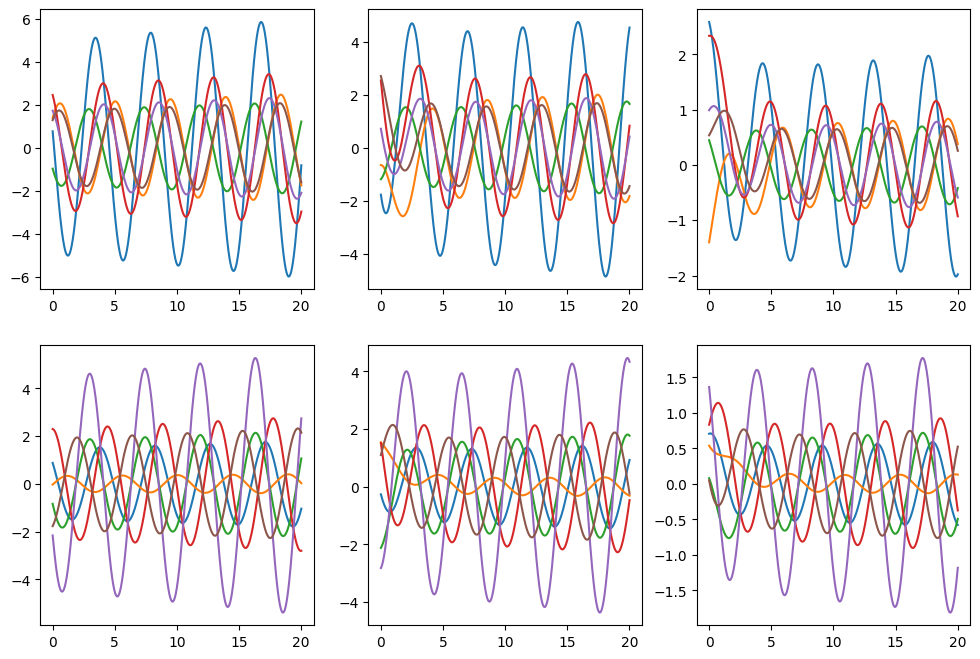

In [ ]:
# Plot to verify networks are converging.

Q = 6 # number of trajectories to plot.
a = np.random.randint(N, size=Q) # randomly sample Q out of N trajectories.
z = Q*0 # for plotting different states

if device == torch.device("cuda"):
  X = X.cpu()

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(2, 3, 1)
ax2 = fig.add_subplot(2, 3, 2)
ax3 = fig.add_subplot(2, 3, 3)
ax4 = fig.add_subplot(2, 3, 4)
ax5 = fig.add_subplot(2, 3, 5)
ax6 = fig.add_subplot(2, 3, 6)

for j in range(Q):
  ax1.plot(T, X[a[j],:,0+z])
  ax2.plot(T, X[a[j],:,1+z])
  ax3.plot(T, X[a[j],:,2+z])
  ax4.plot(T, X[a[j],:,3+z])
  ax5.plot(T, X[a[j],:,4+z])
  ax6.plot(T, X[a[j],:,5+z])

In [47]:
# Save data
exp_setup = {'name':name, 'OOD':OOD, 'N':N, 'time':time, 'q':q, 'n':n, 'k':k, 'g':g, 'AG':AG, 'BG':BG,
             'CG':CG, 'bxG':bxG, 'PG':PG, 'L':L, 'min_axis':min_axis1, 'max_axis':max_axis1}

with open(data_path+'exp_setup.npy', 'wb') as f:
    np.save(f, exp_setup)
with open(data_path+'X.npy', 'wb') as f:
     X = torch.transpose(X,0,1) # (tmax, N=batch*bs, n)
     np.save(f, X)
with open(data_path+'T.npy', 'wb') as f:
     np.save(f, T)
